## Import libraries and data

In [1]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

from scipy.stats.mstats import winsorize
from sklearn.impute import SimpleImputer
from scipy.stats import mstats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import missingno as msno

In [2]:
df_data = pd.read_csv('dataset_mood_smartphone.csv')

## EDA

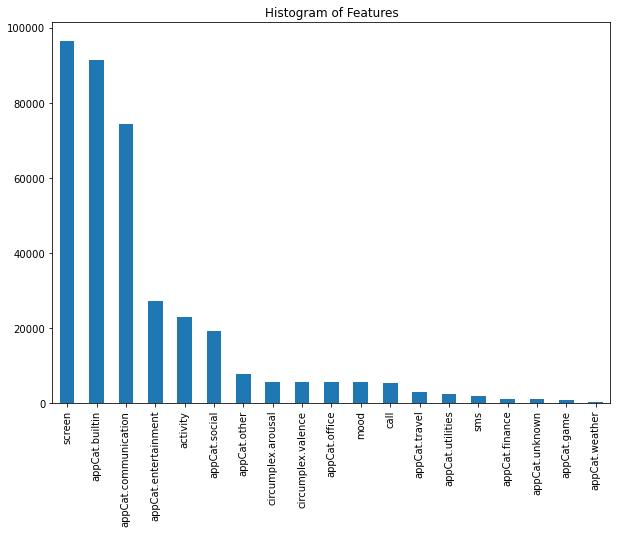

In [3]:
#Checking the count of the variables in the dataset on the basic df we got --> normal csv file
pd.DataFrame(df_data.variable.value_counts()).plot.bar(title="Histogram of Features", legend=None,figsize=(10,7));
#fig.savefig('hist_of_features.pdf')

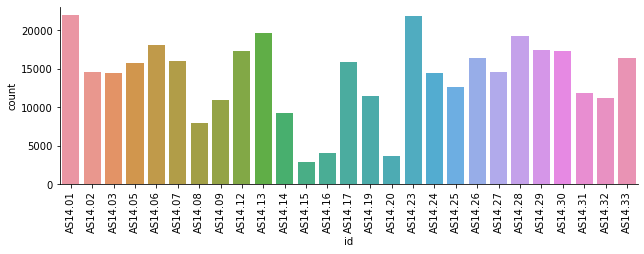

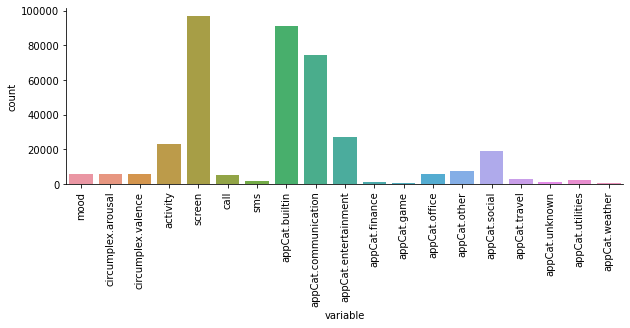

In [4]:
#Countplots of the categorial features
fig_count=sns.catplot(x="id", kind="count", data=df_data, height=3, aspect=3);
plt.xticks(rotation=90);
fig_id=sns.catplot(x="variable", kind="count", data=df_data, height=3, aspect=3);
plt.xticks(rotation=90);

fig_count.savefig('hist_of_ids.pdf')
fig_id.savefig('hist_of_variables.pdf')

In [5]:
# Drop all NA values
df_data = df_data.dropna(0,'any',None,None,False)

In [6]:
df_data.drop('Unnamed: 0', 1,inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Dataframe and feature engineering

In [7]:
# Lists with unique variables and ids
all_variables = list(df_data.variable.unique())
all_ids = list(df_data.id.unique())

In [8]:
# Create usable time columns
df_data[['date','time']] = df_data.time.str.split(" ",expand=True)
start_date = df_data.date.min()
end_date = df_data.date.max()
all_dates = pd.date_range(start_date, end_date)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [9]:
# Create empty dataframe
index_id_date = pd.MultiIndex.from_product([all_ids,all_dates], names = ["Id", "Date"])
data = pd.DataFrame(np.nan,index = index_id_date,columns= all_variables)

In [10]:
count = 0
# for each id
for i in all_ids:

    # for each date
    for d in all_dates:
        d_str = d.strftime('%Y-%m-%d')

        # create df snapshot based on all unique id-date combinations
        df_snapshot = df_data[df_data['date'] == d_str][df_data['id']== i]

        # fill in values based on variable
        for var in list(df_snapshot.variable.unique()):

            # compute daily mean for x variables
            if var in ['mood', 'circumplex.arousal', 'circumplex.valence']:
                var_mean = np.mean(df_snapshot[df_snapshot['variable']== var]['value'])
                data[var][count] = var_mean

            # compute sum for z variables
            else:
                var_sum = np.sum(df_snapshot[df_snapshot['variable']== var]['value'])
                data[var][count] = var_sum
                
        count += 1

<ipython-input-10-c80dbaf752b4>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_snapshot = df_data[df_data['date'] == d_str][df_data['id']== i]


In [11]:
# add counting days variable
data['days_count'] = np.nan
count = 0
for i in all_ids:
    count_days = 0
    for d in all_dates:
        count_days +=1
        data['days_count'][count] = count_days
        count += 1

In [12]:
#df_interpolation(data,all_variables,3)
data.describe()

,mood,circumplex.arousal,circumplex.valence,activity,screen,call,sms,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,days_count
count,1268.000000,1268.000000,1266.000000,1188.000000,1207.000000,1338.000000,734.000000,1195.000000,1183.000000,850.000000,207.000000,193.000000,276.000000,1120.000000,988.000000,429.000000,264.000000,433.000000,113.000000,3051.00000
mean,6.990063,-0.103851,0.687112,2.241571,6027.939920,3.915546,2.449591,1416.168076,2721.389269,1199.131796,98.686865,540.841363,461.558359,176.297251,1402.970122,303.379951,162.023761,106.473192,45.468336,57.00000
std,0.736465,0.662715,0.434602,1.788124,4696.746814,3.555254,2.327730,3841.698865,2466.290266,1921.094754,155.448526,1171.180079,2128.298133,395.155057,1982.361939,720.460894,317.440513,234.074451,53.280275,32.62436
min,3.000000,-2.000000,-1.250000,0.000000,0.462000,1.000000,1.000000,-80367.930000,1.095000,1.014000,1.004000,1.010000,0.044000,2.007000,0.725000,0.080000,0.111000,1.002000,1.007000,1.00000
25%,6.600000,-0.600000,0.400000,0.934891,2423.275500,1.000000,1.000000,262.656000,867.679500,200.786500,27.139000,82.664000,17.101750,44.507750,208.440250,62.299000,22.132250,9.033000,13.111000,29.00000
50%,7.000000,0.000000,0.800000,1.965931,5026.947999,3.000000,1.000000,764.085000,2078.403000,662.026000,49.379000,209.750000,71.999000,65.393000,759.500000,143.316000,66.667000,26.402000,30.386000,57.00000
75%,7.500000,0.400000,1.000000,3.013197,8558.515500,5.000000,3.000000,1558.217000,3789.369000,1551.364500,99.850000,540.616000,271.162750,139.492750,2001.708500,284.954000,176.652250,88.629000,54.055000,85.00000
max,9.333333,2.000000,2.000000,11.535524,36204.105001,31.000000,17.000000,40323.877000,20718.749000,35937.645000,1321.104000,12996.495000,33283.021000,4335.307000,30073.421000,10548.116000,2821.547000,2257.626000,366.937000,113.00000


In [13]:
# Values of appCat.builtin < 0 are impossible, therefore we change these value(s) to NA's. 
count=0
for i in range(len(data)):
    if data['appCat.builtin'][i]<0:
        count+=1
        data['appCat.builtin'][i]=np.nan
print('Number of removed values: {}'.format(count))

Number of removed values: 1


<AxesSubplot:>

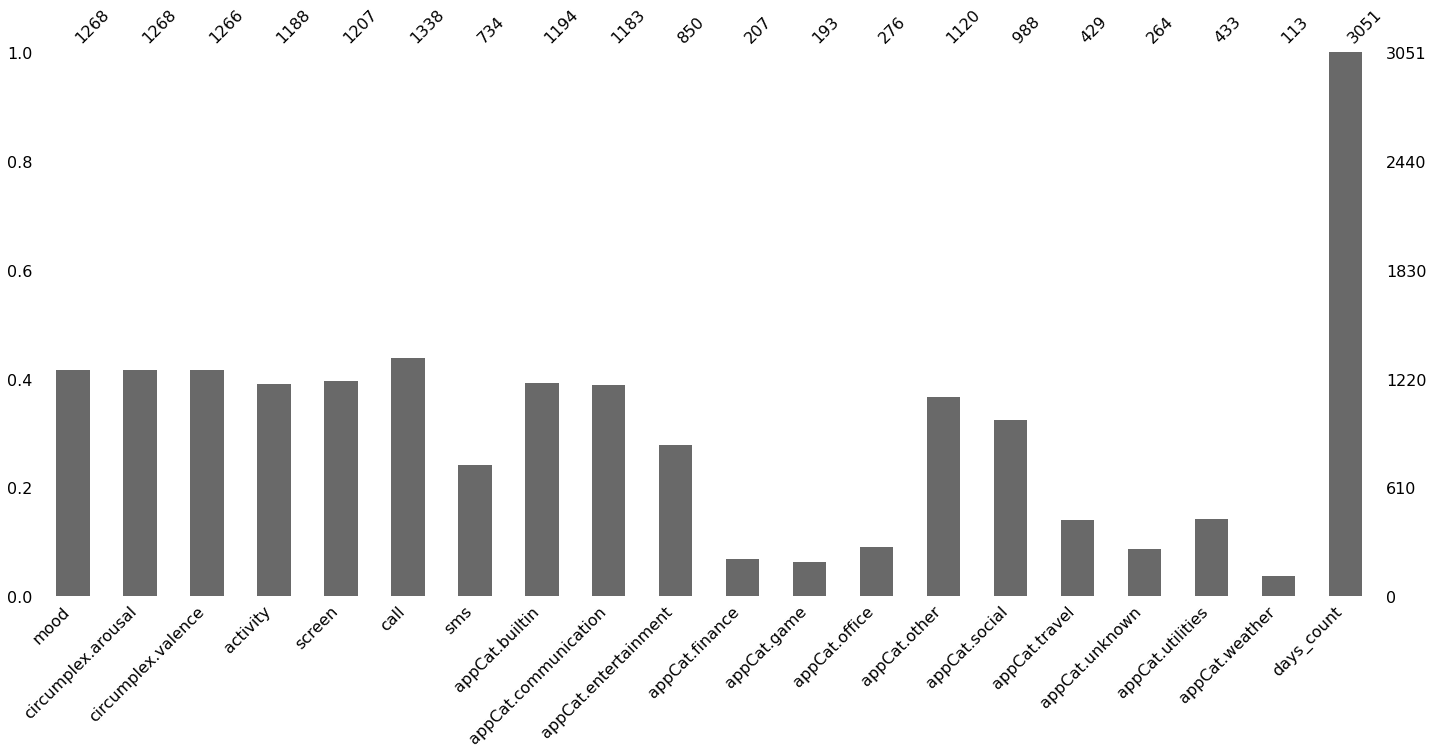

In [14]:
msno.bar(data)

In [15]:
# Deleting large amounts of NA in a row
# deleting groups of rows that contain "NA"s in more than/equal to 2 consecutive days for mood
# !! Argument in Report !! these timewondows wont work/will add noise when aggregating the data
for i in all_ids:
    count = 0
    deathrow = []
    
    for j in np.array(all_dates.strftime('%Y-%m-%d')):
        if np.isnan(data.loc[i,'mood'][j]):
            count += 1
            deathrow.append(j)
            if j == np.array(all_dates.strftime('%Y-%m-%d'))[-1]:
                for d in deathrow:
                    data = data.drop((i, d))
            
                deathrow = []
                count = 0   
        else:
            if count > 2:
                for d in deathrow:
                    data = data.drop((i, d))
            deathrow = []
            count = 0

<AxesSubplot:>

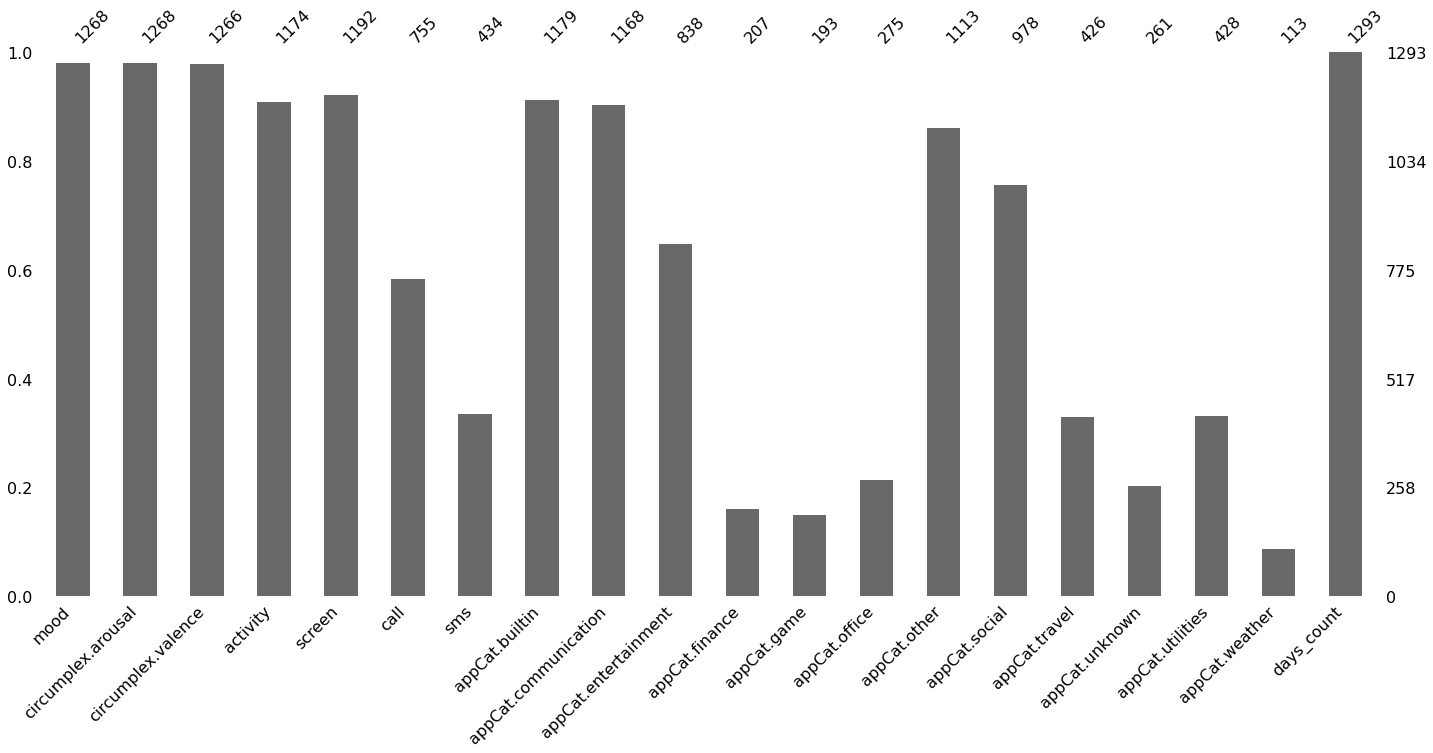

In [16]:
msno.bar(data)

<AxesSubplot:>

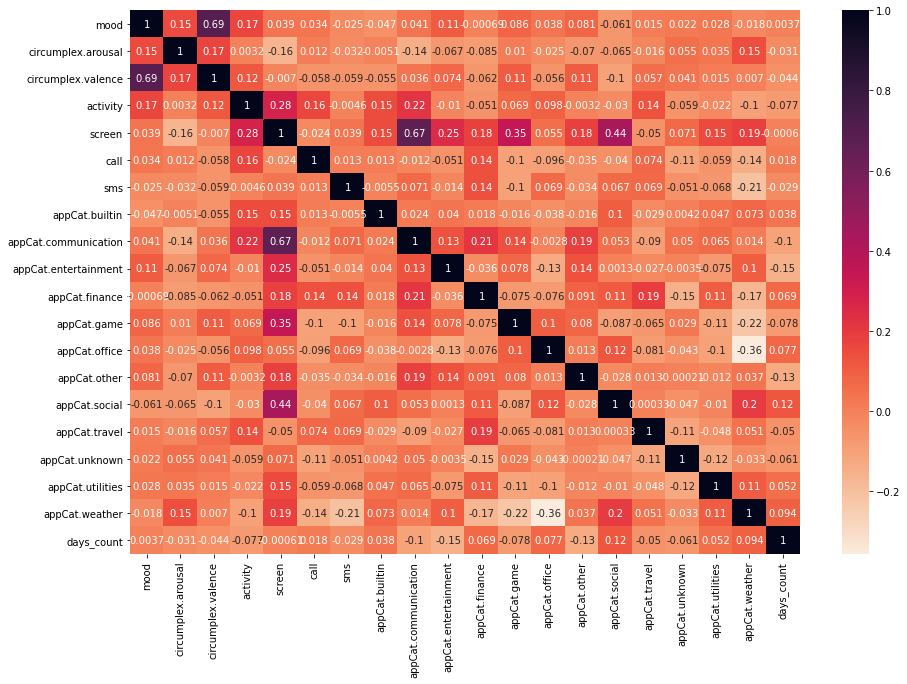

In [17]:
plt.figure(figsize=(15, 10))
cmap = sns.color_palette("rocket_r", as_cmap=True)
sns.heatmap(data.corr(), annot=True, cmap=cmap)

In [18]:
# Combine app categories
# Because of the large amount of NAs in the feature space, it is beneficial to join the various app categories in various caregory categories
# !! Argument in Report !!

# Possiby more features can be created e.g. weekend dummy

data['appCat.professional'] = data[['appCat.office', 'appCat.finance']].sum(axis=1, skipna=True)
data['appCat.recreation'] = data[['appCat.game','appCat.entertainment','appCat.social']].sum(axis=1, skipna=True)
data['appCat.convenience'] = data[['appCat.travel','appCat.utilities','appCat.weather']].sum(axis=1, skipna=True)
data['appCat.plain_usage'] = data[['appCat.other','appCat.unknown','appCat.builtin']].sum(axis=1, skipna=True)
column_names = ['appCat.builtin','appCat.entertainment','appCat.finance','appCat.game','appCat.office','appCat.other','appCat.social','appCat.travel','appCat.unknown','appCat.utilities','appCat.weather']
data = data.drop(columns=column_names, axis=1)

In [19]:
# for binary varibales: replace nan with zero
data['call'] = data['call'].fillna(0)
data['sms'] = data['sms'].fillna(0)

In [20]:
# maybe no treatment of missing values needed if backwards aggregation is used
backup = data.copy()

<AxesSubplot:>

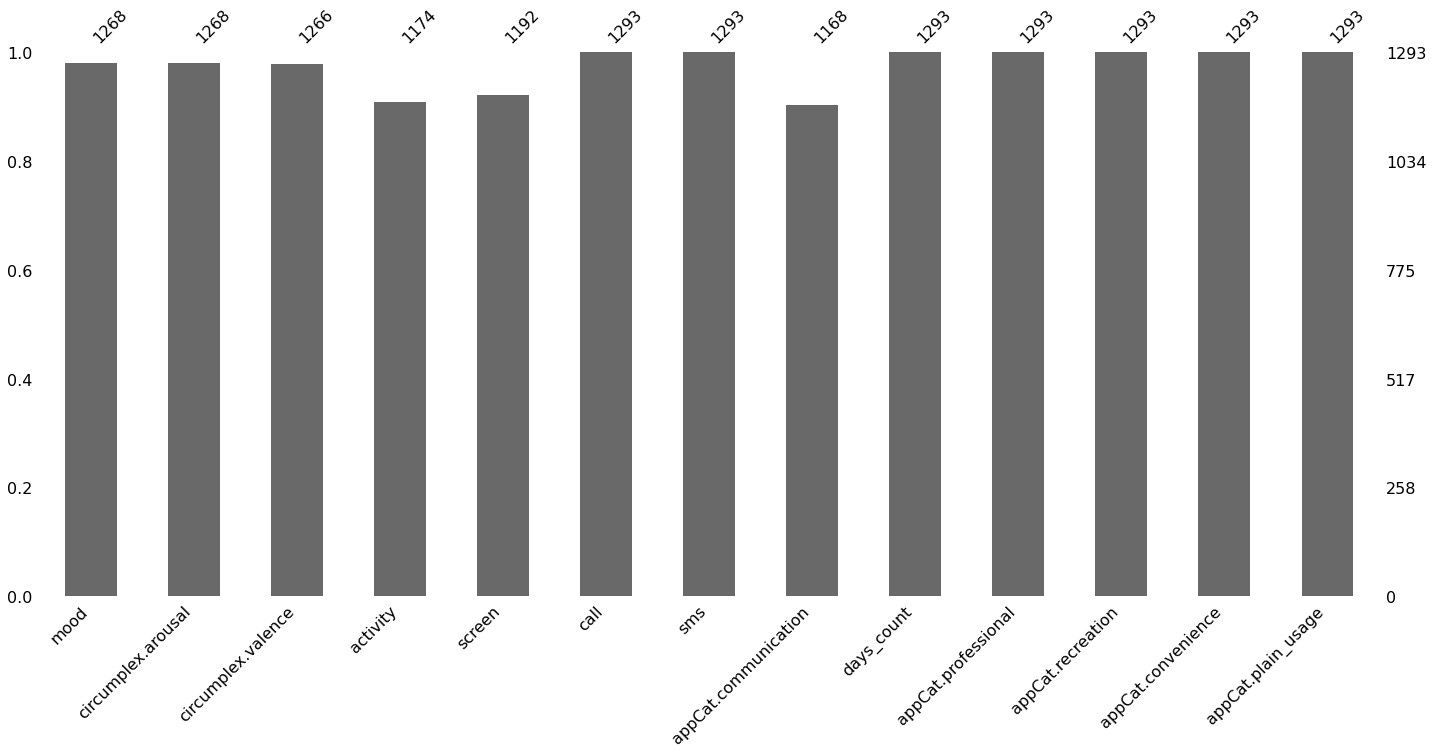

In [21]:
msno.bar(backup)

In [22]:
backup.isna().sum()

mood                     25
circumplex.arousal       25
circumplex.valence       27
activity                119
screen                  101
call                      0
sms                       0
appCat.communication    125
days_count                0
appCat.professional       0
appCat.recreation         0
appCat.convenience        0
appCat.plain_usage        0
dtype: int64

In [23]:
backup.reset_index(inplace=True)
backup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1293 entries, 0 to 1292
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Id                    1293 non-null   object        
 1   Date                  1293 non-null   datetime64[ns]
 2   mood                  1268 non-null   float64       
 3   circumplex.arousal    1268 non-null   float64       
 4   circumplex.valence    1266 non-null   float64       
 5   activity              1174 non-null   float64       
 6   screen                1192 non-null   float64       
 7   call                  1293 non-null   float64       
 8   sms                   1293 non-null   float64       
 9   appCat.communication  1168 non-null   float64       
 10  days_count            1293 non-null   float64       
 11  appCat.professional   1293 non-null   float64       
 12  appCat.recreation     1293 non-null   float64       
 13  appCat.convenience

## Imputation of missing values by mean

In [24]:
list_mood = []

for i in all_ids:
    X = backup[backup.Id.values == i].iloc[:,2]    # create subset of data for each Id which is X
    mean = X.mean()
    X.fillna(mean, inplace=True)

    list_mood.extend(np.array(X))
    
backup['mood'] = list_mood

In [25]:
list_circumplex_arousal = []

for i in all_ids:
    X = backup[backup.Id.values == i].iloc[:,3]    # create subset of data for each Id which is X
    mean = X.mean()
    X.fillna(mean, inplace=True)

    list_circumplex_arousal.extend(np.array(X))
    
backup['circumplex.arousal'] = list_circumplex_arousal

In [26]:
list_circumplex_valence = []

for i in all_ids:
    X = backup[backup.Id.values == i].iloc[:,4]    # create subset of data for each Id which is X
    mean = X.mean()
    X.fillna(mean, inplace=True)

    list_circumplex_valence.extend(np.array(X))
    
backup['circumplex.valence'] = list_circumplex_valence

In [27]:
list_activity = []

for i in all_ids:
    X = backup[backup.Id.values == i].iloc[:,5]    # create subset of data for each Id which is X
    mean = X.mean()
    X.fillna(mean, inplace=True)

    list_activity.extend(np.array(X))
    
backup['activity'] = list_activity

In [28]:
list_screen = []

for i in all_ids:
    X = backup[backup.Id.values == i].iloc[:,6]    # create subset of data for each Id which is X
    mean = X.mean()
    X.fillna(mean, inplace=True)

    list_screen.extend(np.array(X))
    
backup['screen'] = list_screen

In [29]:
list_appCat_communication = []

for i in all_ids:
    X = backup[backup.Id.values == i].iloc[:,9]    # create subset of data for each Id which is X
    mean = X.mean()
    X.fillna(mean, inplace=True)

    list_appCat_communication.extend(np.array(X))
    
backup['appCat.communication'] = list_appCat_communication

In [30]:
backup.set_index(['Id','Date'], inplace = True)

In [31]:
data_pre = backup[2:].copy()

In [32]:
data_pre.isna().sum()

mood                    0
circumplex.arousal      0
circumplex.valence      0
activity                0
screen                  0
call                    0
sms                     0
appCat.communication    0
days_count              0
appCat.professional     0
appCat.recreation       0
appCat.convenience      0
appCat.plain_usage      0
dtype: int64

In [33]:
data_pre.head(10)

mood  circumplex.arousal  circumplex.valence  activity  \
Id      Date                                                                 
AS14.01 2014-03-21  6.20                 0.2                0.20  3.083152   
        2014-03-22  6.40                 0.6                0.50  3.790084   
        2014-03-23  6.80                 0.2                0.80  2.141117   
        2014-03-24  6.00                 0.8                0.00  1.895065   
        2014-03-25  6.75                 0.5                0.50  2.360979   
        2014-03-26  6.60                -0.2                0.60  2.431400   
        2014-03-27  7.00                 0.2                0.80  3.509234   
        2014-03-28  6.40                -0.6                0.60  2.296753   
        2014-03-29  8.00                 0.2                1.00  1.636867   
        2014-03-30  7.50                -0.5                0.75  0.687302   

                          screen  call  sms  appCat.communication  days_count  \
Id      Date                                                                    
AS14.01 2014-03-21  17978.907000   6.0  0.0              6280.890        33.0   
        2014-03-22   6142.161000   3.0  1.0              4962.918        34.0   
        2014-03-23   6773.832001   0.0  0.0              5237.319        35.0   
        2014-03-24  15047.351001  10.0  0.0              9270.629        36.0   
        2014-03-25  21475.354999   0.0  1.0             10276.751        37.0   
        2014-03-26  16423.801000   0.0  0.0              8988.753        38.0   
        2014-03-27  17442.149999   2.0  1.0              6936.512        39.0   
        2014-03-28   4923.489000   5.0  0.0               866.833        40.0   
        2014-03-29   8322.622000   4.0  1.0              2720.692        41.0   
        2014-03-30   4523.214001   0.0  0.0              1298.505        42.0   

                    appCat.professional  appCat.recreation  \
Id      Date                                                 
AS14.01 2014-03-21              221.750           5515.956   
        2014-03-22               21.076            532.956   
        2014-03-23               43.403            995.185   
        2014-03-24               37.116           4200.597   
        2014-03-25               43.054           1987.677   
        2014-03-26               52.331           5502.538   
        2014-03-27              224.670           1574.720   
        2014-03-28               89.166           1751.180   
        2014-03-29                0.000           2100.317   
        2014-03-30                0.000           1703.362   

                    appCat.convenience  appCat.plain_usage  
Id      Date                                                
AS14.01 2014-03-21            1514.199            3378.969  
        2014-03-22             154.926             829.572  
        2014-03-23              60.472            1359.069  
        2014-03-24             598.537             933.514  
        2014-03-25             222.893            1446.810  
        2014-03-26              33.365            1264.995  
        2014-03-27             226.343            1287.859  
        2014-03-28            1434.726           10288.546  
        2014-03-29             653.072            2122.224  
        2014-03-30              38.296             554.845

In [34]:
var_list = list(data_pre.columns)
var_list.remove('days_count')

In [35]:
var_list

['mood',
 'circumplex.arousal',
 'circumplex.valence',
 'activity',
 'screen',
 'call',
 'sms',
 'appCat.communication',
 'appCat.professional',
 'appCat.recreation',
 'appCat.convenience',
 'appCat.plain_usage']

## Rolling window implementation

In [36]:
data_pre.reset_index(inplace=True)
data_pre.set_index(['Id','Date','days_count'],inplace=True,drop=True)

In [37]:
# 2 days - compute average over days for each id sperately

variables = var_list

for var in variables:
        data_pre[str(var)+'_2dayavg'] = np.nan

for i in all_ids:
    for var in variables:
        a = data_pre.loc[i].index
        for j in np.arange(2,len(a)):
            data_pre.loc[i,str(var)+'_2dayavg'][a[j]] = (data_pre.loc[i,var][a[j-1]]+data_pre.loc[i,var][a[j-2]])/2

In [38]:
# 3 days - compute average over days for each id sperately

variables = var_list

for var in variables:
        data_pre[str(var)+'_3dayavg'] = np.nan

for i in all_ids:
    for var in variables:
        a = data_pre.loc[i].index
        for j in np.arange(3,len(a)):
            data_pre.loc[i,str(var)+'_3dayavg'][a[j]] = (data_pre.loc[i,var][a[j-1]]+data_pre.loc[i,var][a[j-2]]+data_pre.loc[i,var][a[j-3]])/3

In [39]:
# 4 days - compute average over days for each id sperately

variables = var_list

for var in variables:
        data_pre[str(var)+'_4dayavg'] = np.nan

for i in all_ids:
    for var in variables:
        a = data_pre.loc[i].index
        for j in np.arange(4,len(a)):
            data_pre.loc[i,str(var)+'_4dayavg'][a[j]] = (data_pre.loc[i,var][a[j-1]]+data_pre.loc[i,var][a[j-2]]+data_pre.loc[i,var][a[j-3]]+data_pre.loc[i,var][a[j-4]])/4

In [40]:
# 5 days - compute average over days for each id sperately

variables = var_list

for var in variables:
        data_pre[str(var)+'_5dayavg'] = np.nan

for i in all_ids:
    for var in variables:
        a = data_pre.loc[i].index
        for j in np.arange(5,len(a)):
            data_pre.loc[i,str(var)+'_5dayavg'][a[j]] = (data_pre.loc[i,var][a[j-1]]+data_pre.loc[i,var][a[j-2]]+data_pre.loc[i,var][a[j-3]]+data_pre.loc[i,var][a[j-4]]+data_pre.loc[i,var][a[j-5]])/5

In [41]:
# consider shift of mood over days for each id sperately

data_pre['target'] = np.nan

for i in all_ids:
        a = data_pre.loc[i].index
        for j in np.arange(1,len(a)):
            data_pre.loc[i,'target'][a[j]] = data_pre.loc[i,'mood'][a[j-1]]

## Feature selection

In [42]:
corr_matrix = data_pre.corr()
corr_matrix['target'].sort_values(ascending=False)

target          1.000000
mood_2dayavg    0.856914
mood_3dayavg    0.784597
mood_4dayavg    0.725662
mood_5dayavg    0.697240
                  ...   
sms_2dayavg    -0.055760
sms            -0.059222
sms_3dayavg    -0.083883
sms_4dayavg    -0.100160
sms_5dayavg    -0.114713
Name: target, Length: 61, dtype: float64

In [43]:
# remove non-avg columns
# drop nan's
data_post = data_pre.iloc[:,11:23]
data_post['target'] = data_pre['target']
data_post.dropna(inplace=True)
data_post.head(10)

<ipython-input-43-5a6de43a11f6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_post['target'] = data_pre['target']
<ipython-input-43-5a6de43a11f6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_post.dropna(inplace=True)


appCat.plain_usage  mood_2dayavg  \
Id      Date       days_count                                     
AS14.01 2014-03-23 35.0                  1359.069         6.300   
        2014-03-24 36.0                   933.514         6.600   
        2014-03-25 37.0                  1446.810         6.400   
        2014-03-26 38.0                  1264.995         6.375   
        2014-03-27 39.0                  1287.859         6.675   
        2014-03-28 40.0                 10288.546         6.800   
        2014-03-29 41.0                  2122.224         6.700   
        2014-03-30 42.0                   554.845         7.200   
        2014-03-31 43.0                  3259.249         7.750   
        2014-04-01 44.0                  1506.707         7.450   

                               circumplex.arousal_2dayavg  \
Id      Date       days_count                               
AS14.01 2014-03-23 35.0                              0.40   
        2014-03-24 36.0                              0.40   
        2014-03-25 37.0                              0.50   
        2014-03-26 38.0                              0.65   
        2014-03-27 39.0                              0.15   
        2014-03-28 40.0                              0.00   
        2014-03-29 41.0                             -0.20   
        2014-03-30 42.0                             -0.20   
        2014-03-31 43.0                             -0.15   
        2014-04-01 44.0                             -0.25   

                               circumplex.valence_2dayavg  activity_2dayavg  \
Id      Date       days_count                                                 
AS14.01 2014-03-23 35.0                             0.350          3.436618   
        2014-03-24 36.0                             0.650          2.965600   
        2014-03-25 37.0                             0.400          2.018091   
        2014-03-26 38.0                             0.250          2.128022   
        2014-03-27 39.0                             0.550          2.396189   
        2014-03-28 40.0                             0.700          2.970317   
        2014-03-29 41.0                             0.700          2.902993   
        2014-03-30 42.0                             0.800          1.966810   
        2014-03-31 43.0                             0.875          1.162085   
        2014-04-01 44.0                             0.675          1.189717   

                               screen_2dayavg  call_2dayavg  sms_2dayavg  \
Id      Date       days_count                                              
AS14.01 2014-03-23 35.0          12060.534000           4.5          0.5   
        2014-03-24 36.0           6457.996500           1.5          0.5   
        2014-03-25 37.0          10910.591501           5.0          0.0   
        2014-03-26 38.0          18261.353000           5.0          0.5   
        2014-03-27 39.0          18949.578000           0.0          0.5   
        2014-03-28 40.0          16932.975500           1.0          0.5   
        2014-03-29 41.0          11182.819499           3.5          0.5   
        2014-03-30 42.0           6623.055500           4.5          0.5   
        2014-03-31 43.0           6422.918000           2.0          0.5   
        2014-04-01 44.0           8180.024001           3.0          0.0   

                               appCat.communication_2dayavg  \
Id      Date       days_count                                 
AS14.01 2014-03-23 35.0                           5621.9040   
        2014-03-24 36.0                           5100.1185   
        2014-03-25 37.0                           7253.9740   
        2014-03-26 38.0                           9773.6900   
        2014-03-27 39.0                           9632.7520   
        2014-03-28 40.0                           7962.6325   
        2014-03-29 41.0                           3901.6725   
        2014-03-30 42.0                           1793.7625   
 

<AxesSubplot:>

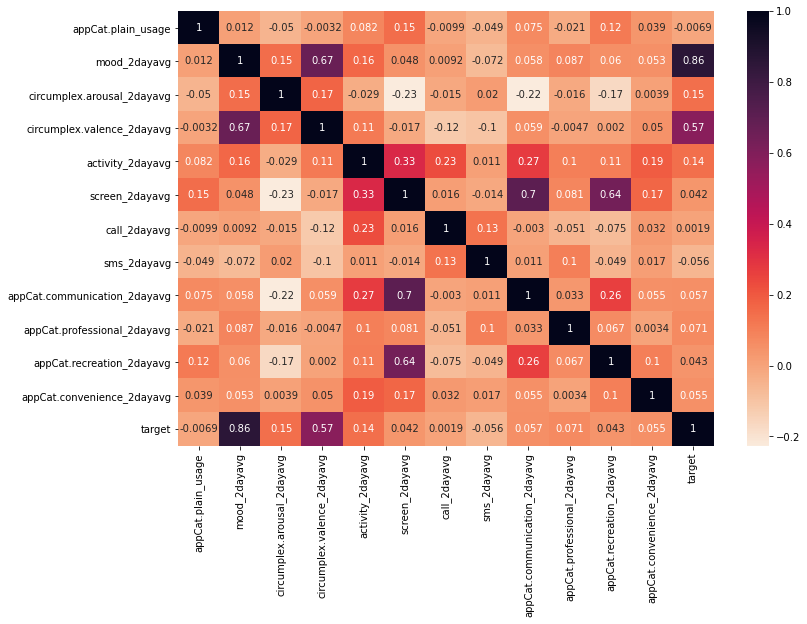

In [44]:
plt.figure(figsize=(12, 8))
cmap = sns.color_palette("rocket_r", as_cmap=True)
sns.heatmap(data_post.corr(), annot=True, cmap=cmap)

In [45]:
data_post.drop(columns=['appCat.plain_usage','call_2dayavg'], inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [46]:
# Data preparations for model training
# - standardize/normalize
# - check for linearity
# - consider special requirements for arima (e.g.stationarity) -> temporal data

In [47]:
# Standardize input features (not target)
from sklearn.preprocessing import MinMaxScaler
minmaxscaler = MinMaxScaler()
df_features = minmaxscaler.fit_transform(data_post.iloc[:,:9])
df_features = pd.DataFrame(data=df_features, columns = data_post.iloc[:,:9].columns)

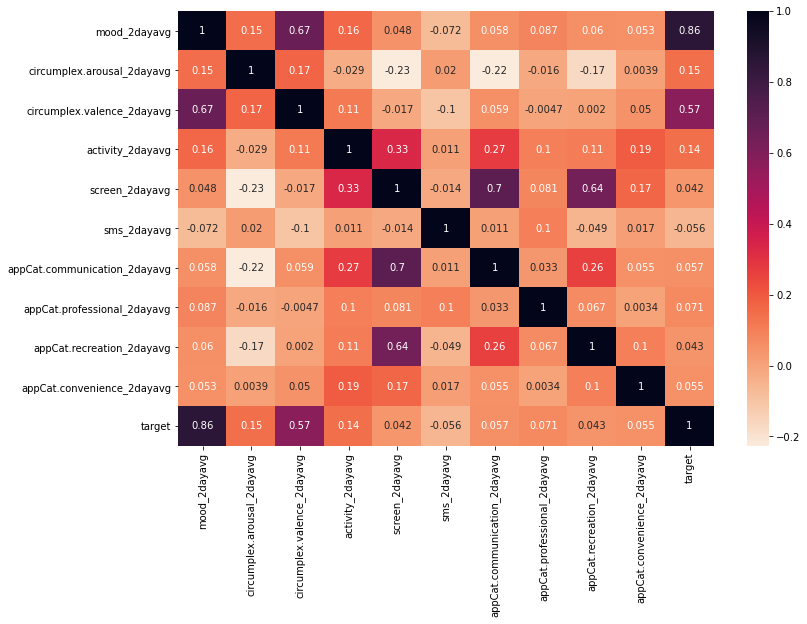

In [48]:
# !! Argument in Report !! which features are selected 
# -correlation approach
# -feature selection apporach (forward/backward)

fig_corr= plt.figure(figsize=(12, 8))
cmap = sns.color_palette("rocket_r", as_cmap=True)
sns.heatmap(data_post.corr(), annot=True, cmap=cmap)

fig_corr.savefig('correlation_.pdf')

## Ramdom Forest
Training

In [49]:
# Grid search can be added
# Feature importance can be added
df_features

,mood_2dayavg,circumplex.arousal_2dayavg,circumplex.valence_2dayavg,activity_2dayavg,screen_2dayavg,sms_2dayavg,appCat.communication_2dayavg,appCat.professional_2dayavg,appCat.recreation_2dayavg
0,0.484574,0.685714,0.482143,0.338506,0.507856,0.041667,0.337123,0.007002,0.148676
1,0.549909,0.685714,0.589286,0.292111,0.271446,0.041667,0.305735,0.001859,0.037560
2,0.506352,0.714286,0.500000,0.198782,0.459332,0.000000,0.435300,0.002322,0.127707
3,0.500907,0.757143,0.446429,0.209610,0.769511,0.041667,0.586873,0.002312,0.152101
4,0.566243,0.614286,0.553571,0.236024,0.798552,0.041667,0.578395,0.002751,0.184101
...,...,...,...,...,...,...,...,...,...
1232,0.381125,0.407143,0.416667,0.256663,0.553146,0.166667,0.083241,0.003764,0.225952
1233,0.375681,0.428571,0.428571,0.088774,0.484521,0.208333,0.098612,0.003764,0.203147
1234,0.680581,0.485714,0.642857,0.137118,0.387376,0.125000,0.119693,0.010321,0.199359
1235,0.767695,0.380952,0.750000,0.322279,0.376394,0.083333,0.070267,0.010321,0.194237


In [50]:
X = df_features
y = data_post['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 12)

In [51]:
rf = RandomForestRegressor(n_estimators = 800, max_depth=3,min_samples_leaf=4,min_samples_split=27,bootstrap=True, random_state = 12)
rf.fit(X_train, y_train)
y_train_pred=rf.predict(X_train)
y_test_pred=rf.predict(X_test)
print('MAE train:', metrics.mean_absolute_error(y_train,y_train_pred))
print('MAE test:', metrics.mean_absolute_error(y_test,y_test_pred))
print('MSE train:', metrics.mean_squared_error(y_train,y_train_pred))
print('MSE test:', metrics.mean_squared_error(y_test,y_test_pred))

MAE train: 0.27215815424845047
MAE test: 0.27335391422508415
MSE train: 0.13567074385544506
MSE test: 0.13226578663643682


In [52]:
data_post['target'].describe()

count    1237.000000
mean        6.990877
std         0.724968
min         3.000000
25%         6.600000
50%         7.000000
75%         7.500000
max         9.333333
Name: target, dtype: float64

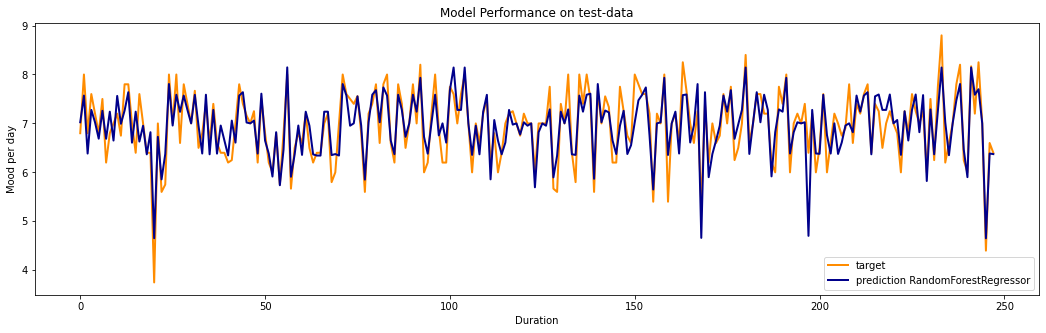

In [53]:
fig_rf =plt.figure(figsize = (18, 5))
plt.plot(np.array(y_test),
        color='darkorange',
        linewidth=2,
        label = 'target')
plt.plot(np.array(y_test_pred),
        color='darkblue',
        linewidth=2,
        label = 'prediction RandomForestRegressor')
plt.xlabel('Duration')
plt.ylabel('Mood per day')
#plt.axis()
plt.legend(loc = 'lower right')
plt.title('Model Performance on test-data')
plt.show()

fig_rf.savefig('rf_target_comparison.pdf')

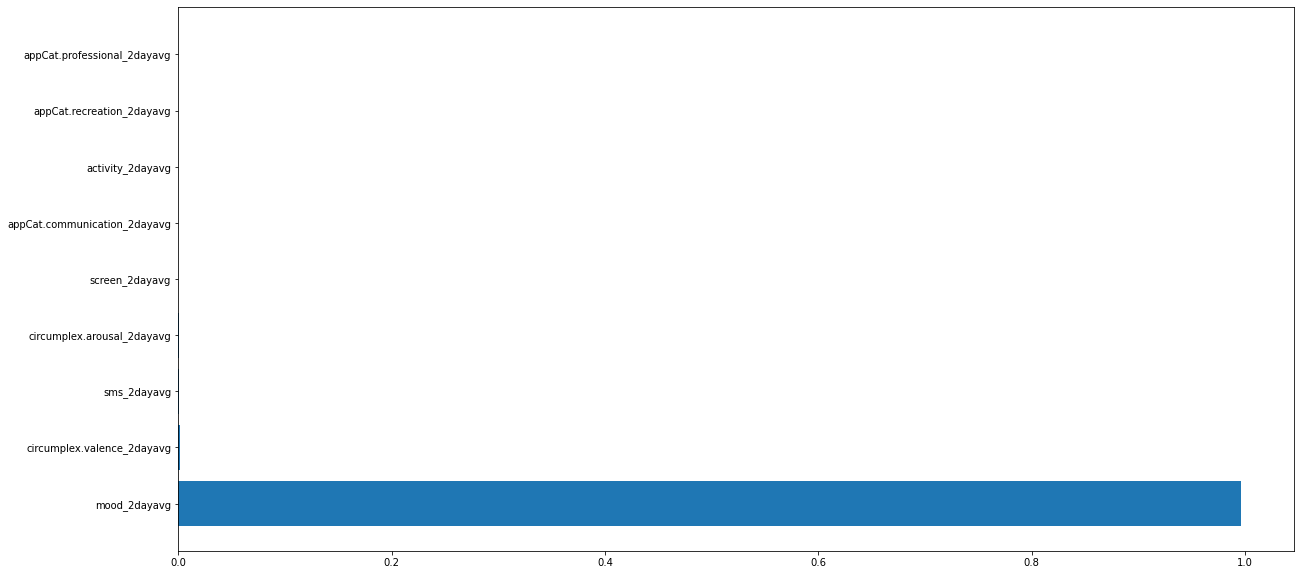

In [54]:
#Feature importance
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)

fig = plt.figure(figsize=(20,10))
plt.barh(feature_importances.index,feature_importances.importance)
# If you want to define your own labels,
# change indices to a list of labels on the following line.
#plt.yticks(range(X.shape[1]), indices)
#plt.ylim([-1, X.shape[1]])
plt.show()
fig.savefig('rf_importance.pdf')

## SVM model

In [55]:
from sklearn.svm import SVR
# Building a Support Vector Machine on train data
svr_model = SVR(C=10, kernel='linear', gamma= 0.0001)
svr_model.fit(X_train, y_train)

y_pred=svr_model.predict(X_test)
  
prediction = svr_model .predict(X_test)
# check the accuracy on the training set
print(svr_model.score(X_train, y_train))
print(svr_model.score(X_test, y_test))

0.731078429777579
0.7458892213545583


In [56]:

#hyper parameter tuning with a grid search 
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear']}
 
grid = GridSearchCV(SVR(), param_grid, refit = True, verbose = 3)
 
# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.673 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.695 total time=   0.0s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.655 total time=   0.0s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.635 total time=   0.0s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.684 total time=   0.0s
[CV 1/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.673 total time=   0.0s
[CV 2/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.695 total time=   0.0s
[CV 3/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.655 total time=   0.0s
[CV 4/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.635 total time=   0.0s
[CV 5/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.684 total time=   0.0s
[CV 1/5] END ..C=0.1, gamma=0.01, kernel=linear;, score=0.673 total time=   0.0s
[CV 2/5] END ..C=0.1, gamma=0.01, kernel=linear

GridSearchCV(estimator=SVR(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['linear']},
             verbose=3)

In [57]:
# print best parameter after tuning
print(grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 10, 'gamma': 1, 'kernel': 'linear'}
SVR(C=10, gamma=1, kernel='linear')


In [58]:
MSE=mean_squared_error(y_test,y_pred)
MAE=mean_absolute_error(y_test,y_pred)
MAPE=mean_absolute_percentage_error(y_test,y_pred)
print(f'MSE is {MSE}')
print(f'MAE is {MAE}')
print(f'MAPE is {MAPE}')

MSE is 0.1291406153018311
MAE is 0.27221196305921164
MAPE is 0.04003384239440681


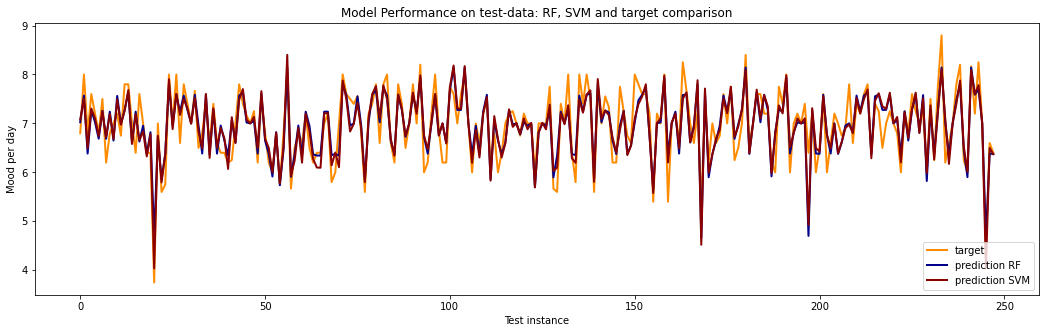

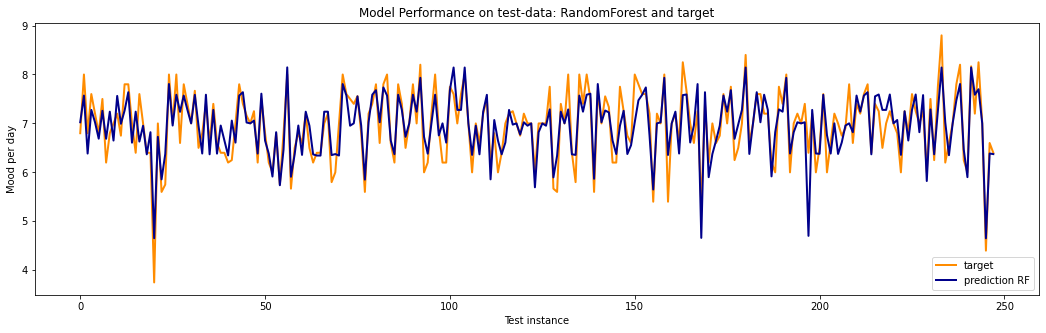

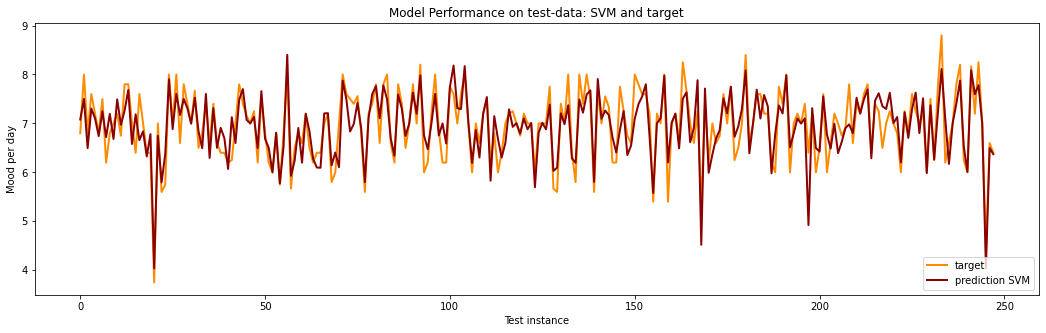

In [59]:
fig_rf_svm=plt.figure(figsize = (18, 5))
plt.plot(np.array(y_test),
        color='darkorange',
        linewidth=2,
        label = 'target')
plt.plot(np.array(y_test_pred),
        color='darkblue',
        linewidth=2,
        label = 'prediction RF')
plt.plot(np.array(y_pred),
        color='darkred',
        linewidth=2,
        label = 'prediction SVM')
plt.xlabel('Test instance')
plt.ylabel('Mood per day')
#plt.axis()
plt.legend(loc = 'lower right')
plt.title('Model Performance on test-data: RF, SVM and target comparison')
plt.show()

plt.figure(figsize = (18, 5))
plt.plot(np.array(y_test),
        color='darkorange',
        linewidth=2,
        label = 'target')
plt.plot(np.array(y_test_pred),
        color='darkblue',
        linewidth=2,
        label = 'prediction RF')
plt.xlabel('Test instance')
plt.ylabel('Mood per day')
#plt.axis()
plt.legend(loc = 'lower right')
plt.title('Model Performance on test-data: RandomForest and target')
plt.show()


fig_svm=plt.figure(figsize = (18, 5))
plt.plot(np.array(y_test),
        color='darkorange',
        linewidth=2,
        label = 'target')
plt.plot(np.array(y_pred),
        color='darkred',
        linewidth=2,
        label = 'prediction SVM')
plt.xlabel('Test instance')
plt.ylabel('Mood per day')
#plt.axis()
plt.legend(loc = 'lower right')
plt.title('Model Performance on test-data: SVM and target')
plt.show()

fig_rf_svm.savefig('SVM_RF_target_pred.pdf')
fig_svm.savefig('SVM_target_pred.pdf')

### SCORE = r2 score

## Benchmark model

In [61]:
data_post1=data_post.copy()
new_variables = ['mood_2dayavg','circumplex.arousal_2dayavg','activity_2dayavg','screen_2dayavg','sms_2dayavg',
                 'circumplex.valence_2dayavg','appCat.recreation_2dayavg','appCat.convenience_2dayavg',
                 'appCat.communication_2dayavg', 'appCat.professional_2dayavg', 'target']


for var in new_variables:
        data_post1[str(var)+'_1lagvalues'] = np.nan

        

for i in all_ids:
    for var in new_variables:
        a = data_post.loc[i].index
        for j in np.arange(1,len(a)):
            data_post1.loc[i,str(var)+'_1lagvalues'][a[j]] = data_post1.loc[i,var][a[j-1]]       

In [62]:
data_post_1=data_post1.dropna()

In [63]:
y_true=data_post_1['target']
y_pred_bm=data_post_1['target_1lagvalues']

In [64]:
MSE_bm=mean_squared_error(y_true,y_pred_bm)
MAE_bm=mean_absolute_error(y_true,y_pred_bm)
MAPE_bm=mean_absolute_percentage_error(y_true,y_pred_bm)
print(f'MSE is {MSE_bm}')
print(f'MAE is {MAE_bm}')
print(f'MAPE is {MAPE_bm}')

MSE is 0.5527533959178843
MAE is 0.5440430840315741
MAPE is 0.08148430500491803


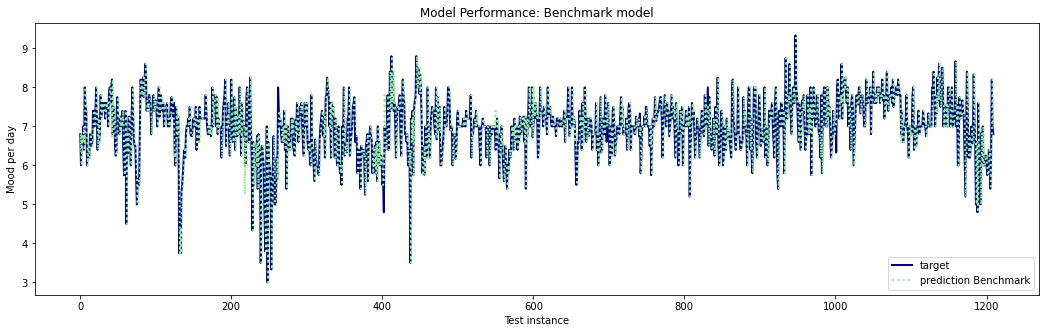

In [65]:
fig_bm=plt.figure(figsize = (18, 5))
plt.plot(np.array(y_true),
        color='darkblue',
        linewidth=2,
        label = 'target')
plt.plot(np.array(y_pred_bm),
        color='lightgreen',
        linestyle= ':',
        linewidth=2,
        label = 'prediction Benchmark')
plt.xlabel('Test instance')
plt.ylabel('Mood per day')
#plt.axis()
plt.legend(loc = 'lower right')
plt.title('Model Performance: Benchmark model')
plt.show()

fig_bm.savefig('benchmark_model.pdf')

## ARIMA - preparation
Check Stationarity

In [66]:
check_mood = pd.DataFrame(data_pre.iloc[:,0])
check_mood.reset_index(inplace=True)

In [ ]:
# choose ids with many dates and values available
# 27,29,31

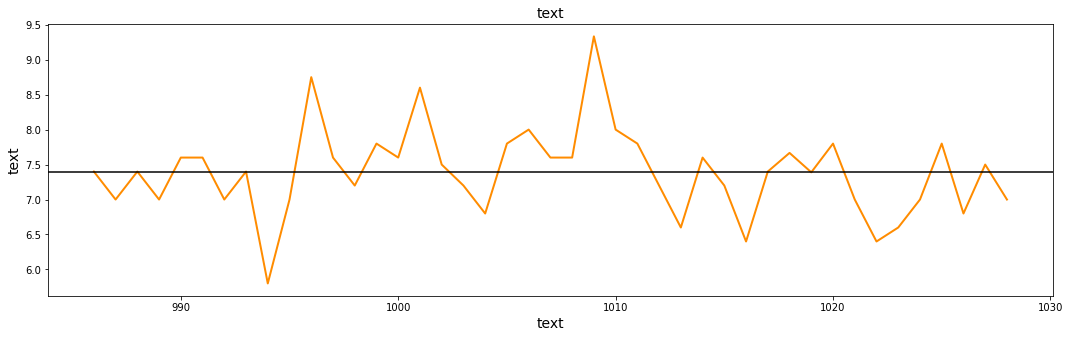

In [67]:
stat_27 = check_mood[(check_mood['Id'] == 'AS14.27')]

plt.figure(figsize = (18, 5))
plt.plot(stat_27['mood'],
        color='darkorange',
        linewidth=2,
        label = 'mood_3dayavg')

plt.axhline(stat_27['mood'].mean(), color='black')

plt.title('text',fontsize=14)
plt.xlabel('text',fontsize=14)
plt.ylabel('text',fontsize=14)
plt.show()

In [68]:
# DF test for id.27

from statsmodels.tsa.stattools import adfuller
series = stat_27['mood']
X = series.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.063402
p-value: 0.000017
Critical Values:
	1%: -3.597
	5%: -2.933
	10%: -2.605


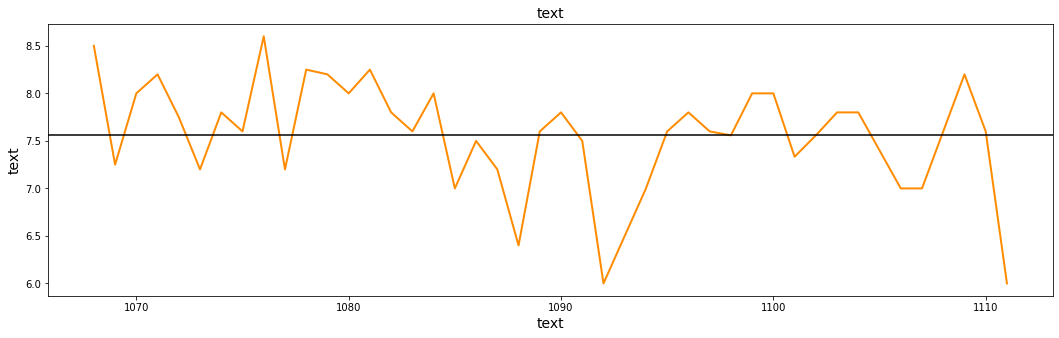

In [69]:
stat_29 = check_mood[(check_mood['Id'] == 'AS14.29')]

plt.figure(figsize = (18, 5))
plt.plot(stat_29['mood'],
        color='darkorange',
        linewidth=2,
        label = 'mood_3dayavg')

plt.axhline(stat_29['mood'].mean(), color='black')

plt.title('text',fontsize=14)
plt.xlabel('text',fontsize=14)
plt.ylabel('text',fontsize=14)
plt.show()

In [70]:
# DF test for id.29

from statsmodels.tsa.stattools import adfuller
series = stat_29['mood']
X = series.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.461907
p-value: 0.009021
Critical Values:
	1%: -3.597
	5%: -2.933
	10%: -2.605


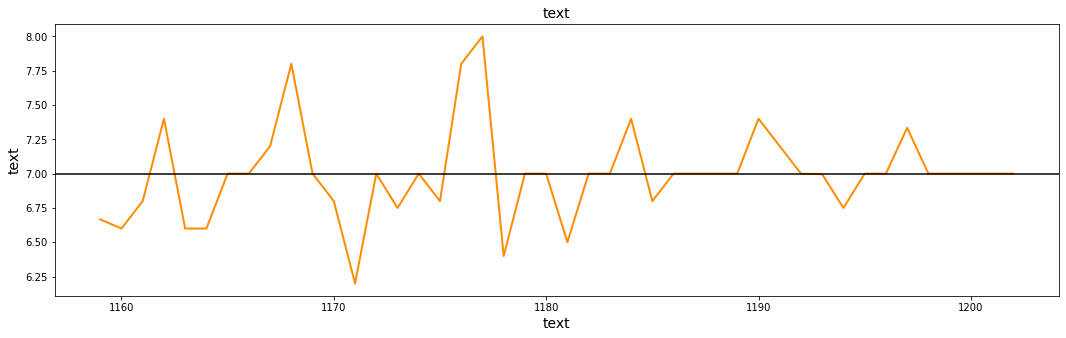

In [71]:
stat_31 = check_mood[(check_mood['Id'] == 'AS14.31')]

plt.figure(figsize = (18, 5))
plt.plot(stat_31['mood'],
        color='darkorange',
        linewidth=2,
        label = 'mood_3dayavg')

plt.axhline(stat_31['mood'].mean(), color='black')

plt.title('text',fontsize=14)
plt.xlabel('text',fontsize=14)
plt.ylabel('text',fontsize=14)
plt.show()

In [72]:
# DF test for id.31

from statsmodels.tsa.stattools import adfuller
series = stat_31['mood']
X = series.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.178945
p-value: 0.000010
Critical Values:
	1%: -3.616
	5%: -2.941
	10%: -2.609


Check (Partial) Autocorrelation

In [73]:
check_mood.set_index(['Date'],inplace=True)

In [74]:
y = check_mood.resample('D').mean()
temp_df = y.iloc[:,:]
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 97 entries, 2014-03-04 to 2014-06-08
Freq: D
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   days_count  97 non-null     float64
 1   mood        97 non-null     float64
dtypes: float64(2)
memory usage: 2.3 KB


In [75]:
# checking the ac and pac over of the daily average over the whole time-series

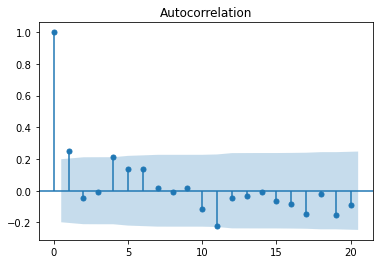

In [76]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(temp_df['mood'].values)
plt.show()

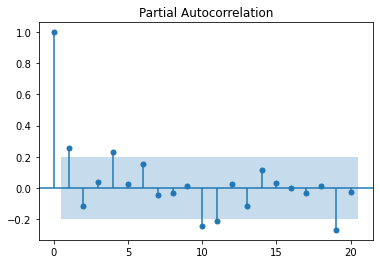

In [77]:
plot_pacf(temp_df['mood'].values)
plt.show()

## Temporal Models

In [78]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow import keras
from tensorflow.keras import layers
from numpy.random import seed

In [79]:
data_temporal_pre = data_pre.copy()
data_temporal_pre.reset_index(drop=False,inplace=True)
data_temporal_pre.set_index(['Id','Date'],inplace=True)
#data_temporal_pre

### Univariate approach - ARIMA
Prediction by using mood only

In [ ]:
univariate = data_temporal_pre.iloc[:,:2]
univariate

days_count  mood
Id      Date                        
AS14.01 2014-03-21        33.0  6.20
        2014-03-22        34.0  6.40
        2014-03-23        35.0  6.80
        2014-03-24        36.0  6.00
        2014-03-25        37.0  6.75
...                        ...   ...
AS14.33 2014-05-27       100.0  6.20
        2014-05-28       101.0  8.20
        2014-05-29       102.0  7.00
        2014-05-30       103.0  6.80
        2014-05-31       104.0  7.00

[1291 rows x 2 columns]

In [ ]:
for i in all_ids:
        a = univariate.loc[i].index
        for j in np.arange(0,len(a)):
            univariate.loc[i,'days_count'][a[j]] = j+1

In [ ]:
univariate.reset_index(drop=False,inplace=True)
#univariate.set_index(['Id','Date','days_count'],drop=True,inplace=True)

In [ ]:
univariate

,Id,Date,days_count,mood
0,AS14.01,2014-03-21,1.0,6.20
1,AS14.01,2014-03-22,2.0,6.40
2,AS14.01,2014-03-23,3.0,6.80
3,AS14.01,2014-03-24,4.0,6.00
4,AS14.01,2014-03-25,5.0,6.75
...,...,...,...,...
1286,AS14.33,2014-05-27,42.0,6.20
1287,AS14.33,2014-05-28,43.0,8.20
1288,AS14.33,2014-05-29,44.0,7.00
1289,AS14.33,2014-05-30,45.0,6.80


In [ ]:
store_models = []
testing = []

for i in all_ids:
    X = univariate[univariate.Id.values == i].iloc[:,range(3,len(univariate.columns))]    # create subset of data for each Id which is X
    
    arima_model = ARIMA(X, order=(2,1,2))
    model = arima_model.fit()
    store_models.append(model)
    x_test = np.array(X)
    testing.extend(x_test.tolist())

/Users/nezasmid/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nezasmid/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nezasmid/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nezasmid/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and w

/Users/nezasmid/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nezasmid/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nezasmid/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nezasmid/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autor

/Users/nezasmid/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nezasmid/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nezasmid/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nezasmid/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Use

In [ ]:
forecast = []

for m in range(0,len(store_models)):
    f = store_models[m].predict()
    ff = np.array(f)
    forecast.extend(ff.tolist())

In [ ]:
df_arima = pd.DataFrame()
df_arima['test'] = univariate['mood'].tolist()
df_arima['forecast'] = forecast
df_arima['test_shift'] = df_arima['test'].shift(periods=1)
df_arima

,test,forecast,test_shift
0,6.20,0.000000,NaN
1,6.40,6.199999,6.2
2,6.80,6.315171,6.4
3,6.00,6.561537,6.8
4,6.75,6.275483,6.0
...,...,...,...
1286,6.20,5.888112,5.4
1287,8.20,6.260682,6.2
1288,7.00,7.050199,8.2
1289,6.80,6.884816,7.0


In [ ]:
list_drop = []
for i in range(0,int(len(df_arima))):
    if df_arima.iloc[i,1] <= 1.0:
        list_drop.append(i)

print(list_drop)

[0, 45, 86, 134, 187, 233, 281, 343, 389, 430, 483, 530, 586, 640, 697, 743, 790, 830, 886, 917, 986, 1029, 1068, 1112, 1159, 1203, 1245]


In [ ]:
for i in list_drop:
    df_arima.drop([i],inplace=True)

In [ ]:
df_arima

,test,forecast,test_shift
1,6.40,6.199999,6.20
2,6.80,6.315171,6.40
3,6.00,6.561537,6.80
4,6.75,6.275483,6.00
5,6.60,6.452747,6.75
...,...,...,...
1286,6.20,5.888112,5.40
1287,8.20,6.260682,6.20
1288,7.00,7.050199,8.20
1289,6.80,6.884816,7.00


In [ ]:
print('MAE test:', metrics.mean_absolute_error(df_arima['test_shift'],df_arima['forecast']))
print('MSE test:', metrics.mean_squared_error(df_arima['test_shift'],df_arima['forecast']))

MAE test: 0.32335520891129405
MSE test: 0.20134187900596165


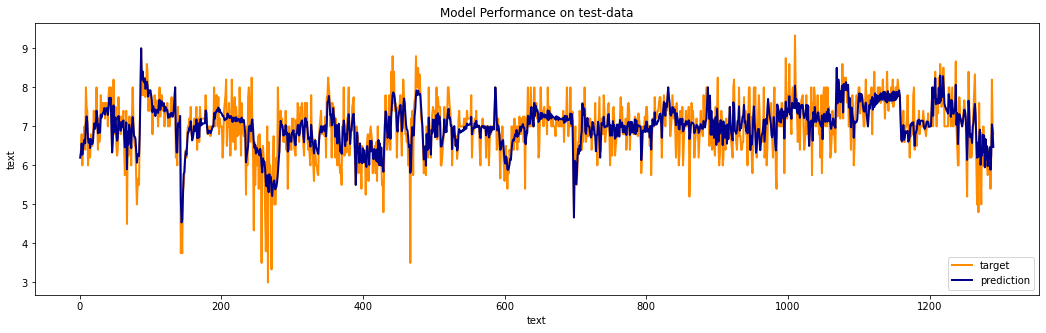

In [ ]:
fig_arima=plt.figure(figsize = (18, 5))
plt.plot(df_arima['test_shift'],
        color='darkorange',
        linewidth=2,
        label = 'target')
plt.plot(df_arima['forecast'],
        color='darkblue',
        linewidth=2,
        label = 'prediction')
plt.xlabel('text')
plt.ylabel('text')
#plt.axis()
plt.legend(loc = 'lower right')
plt.title('Model Performance on test-data')
plt.show()

fig_arima.savefig('target_vs_ARIMA_pred.pdf')

### Multivariate approach - RNN

In [80]:
for i in all_ids:
        a = data_temporal_pre.loc[i].index
        for j in np.arange(0,len(a)):
            data_temporal_pre.loc[i,'days_count'][a[j]] = j+1

In [81]:
data_temporal_pre.reset_index(drop=False,inplace=True)
data_temporal_pre.set_index(['Id','Date','days_count'],drop=True,inplace=True)

In [89]:
data_temporal = data_temporal_pre.iloc[:,:11].copy()
data_temporal

mood  circumplex.arousal  circumplex.valence  \
Id      Date       days_count                                                 
AS14.01 2014-03-21 1.0         6.20            0.200000                 0.2   
        2014-03-22 2.0         6.40            0.600000                 0.5   
        2014-03-23 3.0         6.80            0.200000                 0.8   
        2014-03-24 4.0         6.00            0.800000                 0.0   
        2014-03-25 5.0         6.75            0.500000                 0.5   
...                             ...                 ...                 ...   
AS14.33 2014-05-27 42.0        6.20           -0.600000                 0.4   
        2014-05-28 43.0        8.20            0.000000                 1.2   
        2014-05-29 44.0        7.00           -1.333333                 1.0   
        2014-05-30 45.0        6.80           -0.800000                -0.4   
        2014-05-31 46.0        7.00           -2.000000                 1.0   

                               activity        screen  call  sms  \
Id      Date       days_count                                      
AS14.01 2014-03-21 1.0         3.083152  17978.907000   6.0  0.0   
        2014-03-22 2.0         3.790084   6142.161000   3.0  1.0   
        2014-03-23 3.0         2.141117   6773.832001   0.0  0.0   
        2014-03-24 4.0         1.895065  15047.351001  10.0  0.0   
        2014-03-25 5.0         2.360979  21475.354999   0.0  1.0   
...                                 ...           ...   ...  ...   
AS14.33 2014-05-27 42.0        0.304902   4089.879001   1.0  2.0   
        2014-05-28 43.0        2.479228  14320.867998  10.0  1.0   
        2014-05-29 44.0        4.064507   3569.341000   5.0  1.0   
        2014-05-30 45.0        4.050925   9497.646999   4.0  0.0   
        2014-05-31 46.0        2.051662  10662.661378   0.0  0.0   

                               appCat.communication  appCat.professional  \
Id      Date       days_count                                              
AS14.01 2014-03-21 1.0                  6280.890000              221.750   
        2014-03-22 2.0                  4962.918000               21.076   
        2014-03-23 3.0                  5237.319000               43.403   
        2014-03-24 4.0                  9270.629000               37.116   
        2014-03-25 5.0                 10276.751000               43.054   
...                                             ...                  ...   
AS14.33 2014-05-27 42.0                 2078.403000                0.000   
        2014-05-28 43.0                 1936.415000              357.909   
        2014-05-29 44.0                  435.105000                0.000   
        2014-05-30 45.0                 1670.842000                0.000   
        2014-05-31 46.0                 1468.508886                0.000   

                               appCat.recreation  appCat.convenience  
Id      Date       days_count                                         
AS14.01 2014-03-21 1.0                  5515.956            1514.199  
        2014-03-22 2.0                   532.956             154.926  
        2014-03-23 3.0                   995.185              60.472  
        2014-03-24 4.0                  4200.597             598.537  
        2014-03-25 5.0                  1987.677             222.893  
...                                          ...                 ...  
AS14.33 2014-05-27 42.0                 2135.058              56.173  
        2014-05-28 43.0                 5975.917              30.666  
        2014-05-29 44.0                 1926.660               4.138  
        2014-05-30 45.0                 3426.629            1285.473  
        2014-05-31 46.0                    0.000               0.000  

[1291 rows x 11 columns]

In [90]:
# data normalization (except target mood)
from sklearn.preprocessing import MinMaxScaler
minmaxscaler = MinMaxScaler()
for i in all_ids:
        data_temporal.loc[i] = minmaxscaler.fit_transform(data_temporal.loc[i])

data_temporal['target'] = data_temporal_pre['mood']

In [91]:
data_temporal.reset_index(drop=False,inplace=True)
data_temporal.fillna(0,inplace=True)

In [92]:
data_temporal

,Id,Date,days_count,mood,circumplex.arousal,circumplex.valence,activity,screen,call,sms,appCat.communication,appCat.professional,appCat.recreation,appCat.convenience,target
0,AS14.01,2014-03-21,1.0,0.100000,0.707317,0.2,0.598239,0.795447,0.600000,0.00,0.398936,0.164356,0.587631,0.710139,6.20
1,AS14.01,2014-03-22,2.0,0.200000,0.902439,0.5,0.752214,0.205989,0.300000,0.25,0.301821,0.015621,0.027973,0.072658,6.40
2,AS14.01,2014-03-23,3.0,0.400000,0.707317,0.8,0.393056,0.237446,0.000000,0.00,0.322040,0.032169,0.079888,0.028361,6.80
3,AS14.01,2014-03-24,4.0,0.000000,1.000000,0.0,0.339465,0.649459,1.000000,0.00,0.619235,0.027510,0.439899,0.280706,6.00
4,AS14.01,2014-03-25,5.0,0.375000,0.853659,0.5,0.440944,0.969567,0.000000,0.25,0.693372,0.031911,0.191358,0.104534,6.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1286,AS14.33,2014-05-27,42.0,0.388889,0.500000,0.5,0.032044,0.147409,0.032258,0.50,0.302071,0.000000,0.211275,0.043698,6.20
1287,AS14.33,2014-05-28,43.0,0.944444,0.714286,0.9,0.297294,0.614773,0.322581,0.25,0.281364,1.000000,0.591347,0.023856,8.20
1288,AS14.33,2014-05-29,44.0,0.611111,0.238095,0.8,0.490686,0.123630,0.161290,0.25,0.062421,0.000000,0.190653,0.003219,7.00
1289,AS14.33,2014-05-30,45.0,0.555556,0.428571,0.1,0.489029,0.394443,0.129032,0.00,0.242635,0.000000,0.339082,1.000000,6.80


In [94]:
window = 3
t_test = []
t_pred = []

for i in all_ids:
    X = data_temporal[data_temporal.Id.values == i].iloc[:,range(3,len(data_temporal.columns)-1)]    # create subset of data for each Id which is X
    y = data_temporal[data_temporal.Id.values == i].iloc[:,14]

    last = int(len(data_temporal[data_temporal.Id.values == i])/5)     
    X_train = X[:-last]                         # size of training set is 80% of subset (flexible for each Id) - first 80% in terms of rows
    X_test = X[-last-window:]                   # size of test set is 20% of subset (flexible for each Id) - last 20% in terms of rows
    y_train = y[:-last]
    y_test = y[-last-window:]
    in_train = []
    out_train = []
    for j in range(window,len(X_train)):
        in_train.append(np.array(X_train.iloc[j-window:j,:]))       # 5 days sequence of all variables e.g. in first iteration from row 0 to 4
        out_train.append(np.array(y_train.iloc[j]))               # mood value e.g. in first iteration of row 5 # mood is target in temporal dataset, no shift needed
     
    in_train, out_train = np.array(in_train), np.array(out_train)

    in_test = []
    out_test = []
    for j in range(window,len(X_test)):
        in_test.append(np.array(X_test.iloc[j-window:j,:]))           # same as with training subset
        out_test.append(np.array(y_test.iloc[j]))
     
    in_test, out_test = np.array(in_test), np.array(out_test)

    model = Sequential()

    model.add(LSTM(128, input_shape=(in_train.shape[1:]), activation='relu',return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(128, input_shape=(in_train.shape[1:]), activation='relu',return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1, input_shape=([in_train.shape[0],128]), activation='relu'))

    model.compile(loss='mse',optimizer='adam')
    model.fit(in_train, out_train, epochs=100,verbose=0,batch_size=1)

    t_test.extend(out_test.tolist())
    predictions = model.predict(in_test)
    for pred in range(len(predictions)):
        t_pred.append(predictions.tolist()[pred][0])

In [95]:
multi_test = np.array(t_test)
multi_predict = np.array(t_pred)

In [96]:
print('MAE test:', metrics.mean_absolute_error(multi_test,multi_predict))
print('MSE test:', metrics.mean_squared_error(multi_test,multi_predict))

MAE test: 0.6934511671687923
MSE test: 0.9263515411320503


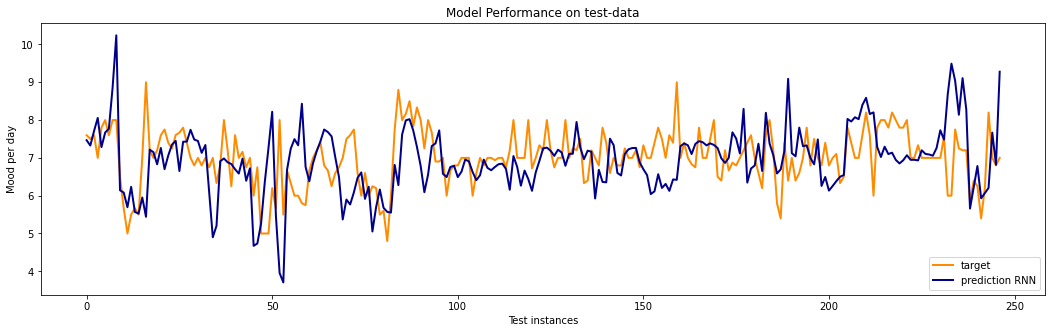

In [97]:
fig_RNN=plt.figure(figsize = (18, 5))
plt.plot(np.array(multi_test),
        color='darkorange',
        linewidth=2,
        label = 'target')
plt.plot(np.array(multi_predict),
        color='darkblue',
        linewidth=2,
        label = 'prediction RNN')
plt.xlabel('Test instances')
plt.ylabel('Mood per day')
#plt.axis()
plt.legend(loc = 'lower right')
plt.title('Model Performance on test-data')
plt.show()

fig_RNN.savefig('RNN_vs_target.pdf')